## Lecture 4 — Data (BCRP + Yahoo) + Plots + Stats + VaR

Reproduce the key parts of the lecture notebook using:

- **Peru (BCRP API)**: `PD04637PD`, `PD04639PD`, `PD04704XD`, `PD04701XD`  
  *(FX + commodities exactly as in the notebook)*
- **USA (yfinance)**: `SPY`, `TLT`, `GLD`

**Deliverables**
- Multiple **plots** (including **one with annotations**)  
- A **summary statistics table**  
- **Historical 95% VaR** for a **60/40 portfolio** (SPY/TLT)

In [61]:
# Core libraries
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import seaborn as sns

# For fetching real financial data
import yfinance as yf

# Date handling
from datetime import datetime, timedelta

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

print("All libraries imported successfully!")

All libraries imported successfully!


1. Build (and display) the **BCRPData API URL** that requests the 4 series used in the notebook.  


In [63]:
# --- BCRP: daily exchange rate PEN/USD buy & sell (official API) ---
# Codes from prompt: PD04637PD, PD04639PD, PD04704XD, PD04701XD
# PD04637PD: USD/PEN (buy)
# PD04639PD: USD/PEN (sell)
# PD04704XD: Gold Price (USD/Oz. Troy)
# PD04701XD: Copper Price (USD/lb.)

import requests
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Define the BCRP series codes and corresponding column names for the wide format
bcrp_series_codes = 'PD04637PD-PD04639PD-PD04704XD-PD04701XD'
bcrp_column_names = ['fx_interbank', 'fx_sbs', 'gold', 'copper']

# Format dates for the API URL
# Ensure start_date and end_date are defined, typically from cell boisMwmKLR8T
if 'start_date' not in globals():
    end_date = datetime.now()
    start_date = end_date - timedelta(days=730)

formatted_start_date = start_date.strftime('%Y-%m-%d')
formatted_end_date = end_date.strftime('%Y-%m-%d')

bcrp_url = f"https://estadisticas.bcrp.gob.pe/estadisticas/series/api/{bcrp_series_codes}/json/{formatted_start_date}/{formatted_end_date}/esp"

try:
    r = requests.get(bcrp_url, timeout=30)
    r.raise_for_status() # Raise an exception for HTTP errors
    bcrp_obj = r.json()
except requests.exceptions.RequestException as e:
    bcrp_obj = {"periods": []}
    print(f"BCRP request failed: {type(e).__name__} - {e}")
except ValueError as e: # Catch JSON decoding errors
    bcrp_obj = {"periods": []}
    print(f"BCRP JSON decoding failed: {type(e).__name__} - {e}")

periods = bcrp_obj.get("periods", [])
rows = []
for p in periods:
    name = p.get("name")
    vals = p.get("values", [])
    if isinstance(vals, str):
        vals = [vals]
    # Ensure there are enough values for all series requested
    if name is None or not isinstance(vals, list) or len(vals) < len(bcrp_column_names):
        continue
    # Handle 'n.d.' (no data) values from BCRP API by converting to NaN
    cleaned_vals = [val if val != 'n.d.' else np.nan for val in vals]
    rows.append([name] + cleaned_vals)

# Create DataFrame with raw date and all series values
bcrp_df_raw_data = pd.DataFrame(rows, columns=["date_raw"] + bcrp_column_names)


# --- Start of code for date and numeric conversion ---

# Create a dictionary for month mapping from Spanish to English
month_map = {
    "Ene": "Jan", "Feb": "Feb", "Mar": "Mar", "Abr": "Apr",
    "May": "May", "Jun": "Jun", "Jul": "Jul", "Ago": "Aug",
    "Sep": "Sep", "Oct": "Oct", "Nov": "Nov", "Dic": "Dec"
}

# Extract and convert the 'date_raw' column to a proper datetime index
idx_series = bcrp_df_raw_data["date_raw"].astype(str)

# Replace month abbreviations to English
for es, en in month_map.items():
    idx_series = idx_series.str.replace(f".{es}.", f".{en}.", regex=False)

# Convert the cleaned date strings to datetime objects
datetime_index = pd.to_datetime(idx_series, format="%d.%b.%y", errors="coerce")

# Set the new datetime index and drop the raw date column
bcrp_data = bcrp_df_raw_data.set_index(datetime_index).drop(columns=["date_raw"])

# Convert values to numeric
bcrp_data = bcrp_data.apply(pd.to_numeric, errors="coerce")

# Clean up to remove any null values that may have been found in the index or data
bcrp_data = bcrp_data[~bcrp_data.index.isna()].sort_index() # Remove rows with NaT in index
bcrp_data = bcrp_data.dropna(how='all') # Drop rows where all data columns are NaN

print("BCRP Data after processing (wide format):")
print(bcrp_data.head())
print(f"Shape: {bcrp_data.shape}")
print(f"Index type: {type(bcrp_data.index)}")


BCRP Data after processing (wide format):
            fx_interbank  fx_sbs   gold  copper
date_raw                                       
2024-01-10          3.70    3.70 375.80 2024.41
2024-01-11          3.70    3.70 377.93 2028.91
2024-01-12          3.69    3.69 375.98 2049.06
2024-01-15          3.69    3.69 373.69 2056.55
2024-01-16          3.72    3.71 375.57 2028.44
Shape: (479, 4)
Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


In [64]:
bcrp_data.head()

,fx_interbank,fx_sbs,gold,copper
date_raw,,,,
2024-01-10,3.70,3.70,375.80,2024.41
2024-01-11,3.70,3.70,377.93,2028.91
2024-01-12,3.69,3.69,375.98,2049.06
2024-01-15,3.69,3.69,373.69,2056.55
2024-01-16,3.72,3.71,375.57,2028.44


In [65]:
# This cell's functionality has been integrated into cell 5JO0hteqMjwH to streamline the BCRP data processing.
# The final wide-format BCRP data is now available in the 'bcrp_data' DataFrame.

2. Download those series and build a **tidy** table: `date`, `series`, `value`.  


3. Clean to **wide format** with columns: `fx_interbank`, `fx_sbs`, `gold`, `copper` (as in the notebook).  


In [66]:
### Download those series and build a tidy table: date, series, value.
# Ensure bcrp_data is available (it's created in the previous cell 5JO0hteqMjwH)

# Reset the index to turn the datetime index into a regular column named 'date'
# Then, use melt to unpivot the DataFrame into a tidy format
bcrp_df_tidy = bcrp_data.reset_index().melt(id_vars=['date_raw'], var_name='series', value_name='value')

# Rename the 'index' column to 'date'
# bcrp_df_tidy = bcrp_df_tidy.rename(columns={'index': 'date'})

print("Tidy BCRP Data (bcrp_df_tidy):")
display(bcrp_df_tidy.head())
print(f"Shape: {bcrp_df_tidy.shape}")

Tidy BCRP Data (bcrp_df_tidy):


,date_raw,series,value
0,2024-01-10,fx_interbank,3.70
1,2024-01-11,fx_interbank,3.70
2,2024-01-12,fx_interbank,3.69
3,2024-01-15,fx_interbank,3.69
4,2024-01-16,fx_interbank,3.72


Shape: (1916, 3)


date_raw    series        value  
2026-01-01  gold          567.53     1
            copper        4339.49    1
2025-12-31  gold          567.53     1
            fx_sbs        3.36       1
            fx_interbank  3.36       1
                                    ..
2024-01-11  copper        2028.91    1
2024-01-10  gold          375.80     1
            fx_sbs        3.70       1
            fx_interbank  3.70       1
            copper        2024.41    1
Name: count, Length: 1856, dtype: int64

In [67]:
### Clean to wide format with columns: fx_interbank, fx_sbs, gold, copper (as in the notebook).


4. Download `SPY`, `TLT`, `GLD` from yfinance and build: `date`, `ticker`, `close`.  


In [62]:
# Define the stocks we want to analyze
tickers = ['SPY', 'TLT', 'GLD']
ticker_names = {
    'SPY': 'S&P500',
    'TLT': 'iShares_20+_Year_Treasury_Bond ETF',
    'GLD': 'Gold',
}

# Set date range (last 2 years)
end_date = datetime.now()
start_date = end_date - timedelta(days=730)

# Download stock data
print("Downloading stock data...")
stock_data = yf.download(tickers, start=start_date, end=end_date, progress=False)

# Handle MultiIndex columns from yfinance
# yfinance returns MultiIndex columns: (Price, Ticker)
if isinstance(stock_data.columns, pd.MultiIndex):
    # Get close prices (yfinance no longer provides Adj Close by default)
    prices = stock_data['Close'].copy()
    volume = stock_data['Volume'].copy()
else:
    # Single ticker case
    prices = stock_data[['Close']].copy()
    prices.columns = [tickers[0]]
    volume = stock_data[['Volume']].copy()
    volume.columns = [tickers[0]]

# Rename columns to company names
prices.columns = [ticker_names.get(col, col) for col in prices.columns]
volume.columns = [ticker_names.get(col, col) for col in volume.columns]

print(f"\nData downloaded from {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")
print(f"Shape: {prices.shape}")
prices.head()


Data downloaded from 2024-01-10 to 2026-01-09
Shape: (501, 3)


,Gold,S&P500,iShares_20+_Year_Treasury_Bond ETF
Date,,,
2024-01-11,187.87,464.86,88.94
2024-01-12,189.71,465.18,88.76
2024-01-16,187.91,463.47,87.20
2024-01-17,185.84,460.90,87.06
2024-01-18,187.37,464.99,86.25


5. Compute **daily returns** by ticker (`ret`) and validate there are **no inf values**.  


In [71]:
###Compute daily returns by ticker (ret) and validate there are no inf values.
prices_ret = prices.pct_change().dropna()
print(f"Shape: {prices_ret.shape}")
prices_ret.head()

Shape: (500, 3)


,Gold,S&P500,iShares_20+_Year_Treasury_Bond ETF
Date,,,
2024-01-12,0.01,0.00,-0.00
2024-01-16,-0.01,-0.00,-0.02
2024-01-17,-0.01,-0.01,-0.00
2024-01-18,0.01,0.01,-0.01
2024-01-19,0.00,0.01,0.00


6. *(Quantities)* Compare FX levels in Peru: produce a **plot** and a short comment.

> Añadir blockquote




In [74]:
### (Quantities) Compare FX levels in Peru: produce a plot and a short comment.
fx = {'fx_sbs', 'fx_interbank'}
bcrp_df_tidy_fx  = bcrp_df_tidy[bcrp_df_tidy['series'].isin(fx)]
bcrp_df_tidy_fx.head()


,date_raw,series,value
0,2024-01-10,fx_interbank,3.70
1,2024-01-11,fx_interbank,3.70
2,2024-01-12,fx_interbank,3.69
3,2024-01-15,fx_interbank,3.69
4,2024-01-16,fx_interbank,3.72


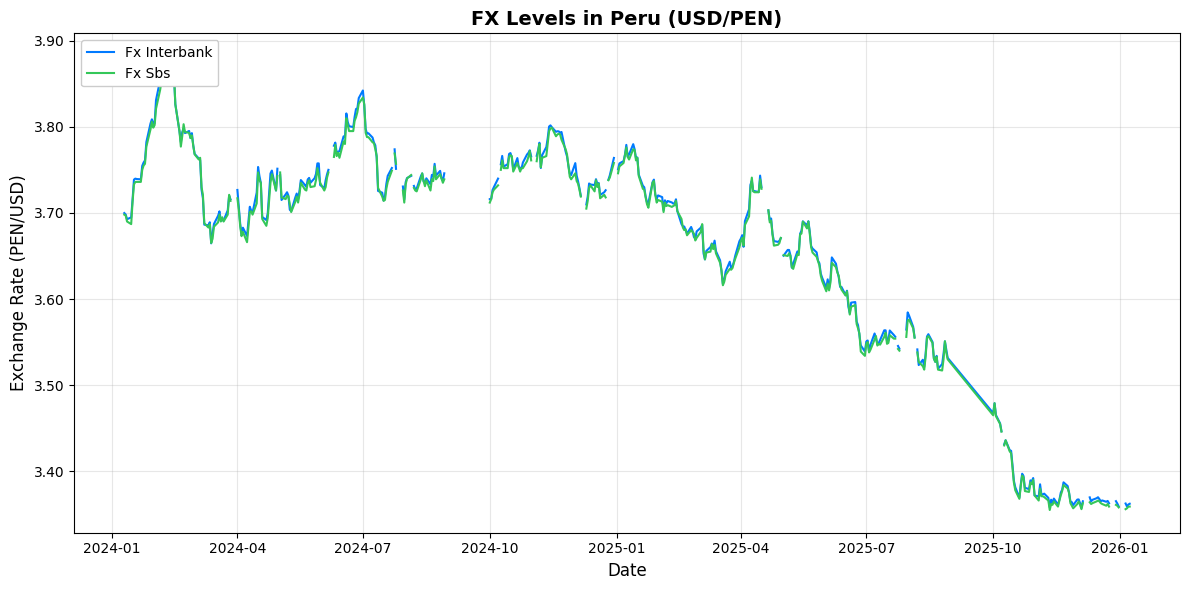

The plot above compares the interbank (fx_interbank) and SBS (fx_sbs) exchange rates in Peru. It shows that both rates track each other very closely, as expected for official exchange rate mechanisms. Any small deviations might reflect minor market inefficiencies or data reporting differences.


In [79]:
# Plot FX levels in Peru
fig, ax = plt.subplots(figsize=(12, 6))

# Define colors for each series (two FX series)
colors = ['#007AFF', '#34C759']
fx_series_names = bcrp_df_tidy_fx['series'].unique()

# Plot each FX series
for i, series_name in enumerate(fx_series_names):
    series_data = bcrp_df_tidy_fx[bcrp_df_tidy_fx['series'] == series_name]
    ax.plot(series_data['date_raw'], series_data['value'], label=series_name.replace('_', ' ').title(), color=colors[i], linewidth=1.5)

ax.set_title('FX Levels in Peru (USD/PEN)', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Exchange Rate (PEN/USD)', fontsize=12)
ax.legend(loc='upper left', framealpha=1)
ax.grid(True, alpha=0.3)

# Format y-axis to show two decimal places for FX rates
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{x:,.2f}'))

plt.tight_layout()
plt.show()

comment = "The plot above compares the interbank (fx_interbank) and SBS (fx_sbs) exchange rates in Peru. It shows that both rates track each other very closely, as expected for official exchange rate mechanisms. Any small deviations might reflect minor market inefficiencies or data reporting differences."
print(comment)


7. *(Proportions)* Compute the **share of positive-return days** by ticker (USA).  


In [82]:
### (Proportions) Compute the share of positive-return days by ticker (USA).

# Calculate the number of positive return days for each ticker
positive_returns_count = (prices_ret > 0).sum()

# Calculate the total number of trading days for each ticker
total_trading_days = prices_ret.count()

# Calculate the share of positive return days
share_positive_returns = (positive_returns_count / total_trading_days) * 100

print("Share of Positive-Return Days by Ticker (%):")
print(share_positive_returns.sort_values(ascending=False).to_string())


Share of Positive-Return Days by Ticker (%):
Gold                                 58.60
S&P500                               58.40
iShares_20+_Year_Treasury_Bond ETF   51.00


8. Plot that share as a **bar chart** and add **labels above each bar** (`annotate`).  


Text(0.5, 1.0, 'Last Close Price')

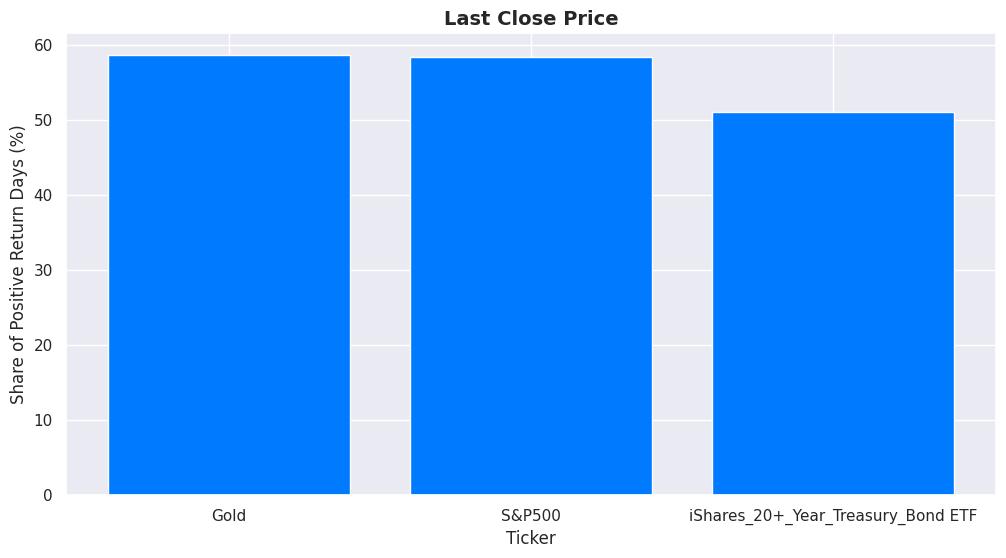

In [102]:
### Plot that share as a bar chart and add labels above each bar (annotate).
last_close_price = prices.iloc[499:-1, :]
last_close_price

plt.figure(figsize=(12, 6))
plt.bar(share_positive_returns.index, share_positive_returns.values,  color='#007AFF')
plt.xlabel('Ticker', fontsize=12)
plt.ylabel('Share of Positive Return Days (%)', fontsize=12)
plt.title('Last Close Price', fontsize=14, fontweight='bold')

9. *(Distributions)* Compare the distribution of **Peru Gold** vs **GLD** (histogram).  


10. Add an **ECDF** (if used in the notebook) and comment on what changes vs the histogram.  


11. *(Relationships)* Build `FX_change` and relate it to `SPY_ret` (scatter plot).  


12. Compute the **correlation** between `FX_change` and `SPY_ret` and explain the sign.  


13. Estimate a simple regression `FX_change ~ SPY_ret` and interpret the coefficient.  


14. *(Pandas)* Do a selection exercise: `.iloc` (position-based) vs conditional filtering.  


15. Create missing data on purpose in one series and apply imputation (as in the notebook).  


16. Standardize a variable (z-score) and plot **before vs after**.  


17. Find the day with the largest `|SPY_ret|` and **annotate it** in the returns plot (like the exercise).  


18. Save one figure into `/figures` using `savefig` and verify the file exists.  


19. Build a **summary stats table** for returns (mean, sd, p5, p95, etc.).  


20. Compute **historical 95% VaR** for a **60/40 portfolio (SPY/TLT)** and explain what it means.
